# Desafio Técnico PDI 

📌 **OBJETIVO** - Considerando que a imagem em questão (encarte de supermercado) será processada por algoritmos de PDI e NLP, você como desenvolverdor do time de processamento de imagens tem a missão de aplicar à imagem algoritmos de pré-processamentos com o objetivo de destacar as regiões de interesse sabendo que cada oferta (nome e preço do produto) serão extraídos pelo time de NLP. Agora é com você, dev PDI ! Dado a imagem em anexo, escreva um código para aplicar os melhores pré-processamentos possíveis, preparando a imagem para o time de NLP.

> NUVEN - Núcleo de Visão Computacional e Engenharia

> Processo seletivo para a vaga **Desenvolvedor(a) em Processamento de Imagens**

> Andressa Gomes Moreira

## Treinamento da rede neural para reconhecimento de texto manuscrito

**Conectar ao drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importações**

In [ ]:
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

tf.__version__

'2.12.0'

### Carregamento da base de dados MNIST

> O conjunto de dados MNIST é uma enorme base de dados de dígitos escritos manualmente utilizada para preparar diferentes sistemas de tratamento de imagens.

> Os dados serão divididos em: 80% treinamento, 20% teste e 20% validação.

In [ ]:
(data_train, label_train), (data_test, label_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
data = np.vstack([data_train, data_test])
labels = np.hstack([label_train, label_test])

In [ ]:
# Divisão em treinamento, teste e validação
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state = 1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state = 1)

In [ ]:
# Shape: Treinamento
print(x_train.shape)
print(y_train.shape)

# Shape: Teste
print(x_test.shape)
print(y_test.shape)

# Shape: Validação
print(x_valid.shape)
print(y_valid.shape)

(44800, 28, 28)
(44800,)
(14000, 28, 28)
(14000,)
(11200, 28, 28)
(11200,)


**Visualizando uma imagem da base MNIST**

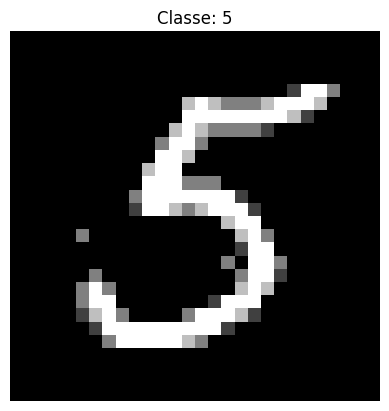

In [ ]:
def plot_img(train, label):
  """Exibe a imagem da base de dados e o seu label.

    Args:
        train: Imagem da base de dados
        label: Label da imagem
    Returns:
        None
    """
  plt.imshow(train, cmap='gray')
  plt.axis('off')
  plt.title('Classe: ' + str(label));

plot_img(x_train[7], y_train[7])

### Pré-processamento dos dados

**Aumento e Normalização dos dados**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')


validation_datagen = ImageDataGenerator(rescale=1./255)

**Categorização das labels com One Hot Enconder**

> Necessário categorizar as labels com One Hot Enconder

In [ ]:
one = LabelBinarizer()
y_train = one.fit_transform(y_train)
y_test = one.fit_transform(y_test)
y_valid = one.fit_transform(y_valid)

In [ ]:
# Numeral 5
y_train[7]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

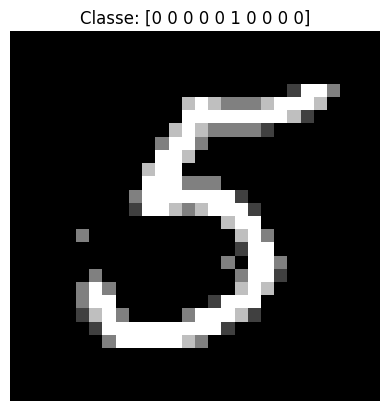

In [ ]:
plot_img(x_train[7], y_train[7])

### Estrutura da rede neural

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

**Reshape dos dados**

In [ ]:
x_train = np.expand_dims(x_train, axis = -1)
x_valid = np.expand_dims(x_valid, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)

In [ ]:
x_train.shape, y_train.shape

((44800, 28, 28, 1), (44800, 10))

**Treinamento do modelo**

In [ ]:
epochs = 500
batch_size = 128
steps_per_epoch = len(x_train) // batch_size

In [ ]:
checkpoint = ModelCheckpoint(r'drive/MyDrive/OCR/CNN_digitos_OCR.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=50, mode='min', verbose=1)

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data = validation_datagen.flow(x_valid, y_valid),
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs, verbose=1, 
                    callbacks=[checkpoint, early_stop])

Epoch 1/500
349/350 [============================>.] - ETA: 0s - loss: 1.3669 - accuracy: 0.5274
Epoch 1: val_loss improved from inf to 0.40716, saving model to drive/MyDrive/OCR/CNN_digitos_OCR.h5
350/350 [==============================] - 28s 51ms/step - loss: 1.3648 - accuracy: 0.5282 - val_loss: 0.4072 - val_accuracy: 0.8619
Epoch 2/500
350/350 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.7827
Epoch 2: val_loss improved from 0.40716 to 0.18717, saving model to drive/MyDrive/OCR/CNN_digitos_OCR.h5
350/350 [==============================] - 20s 57ms/step - loss: 0.6626 - accuracy: 0.7827 - val_loss: 0.1872 - val_accuracy: 0.9438
Epoch 3/500
349/350 [============================>.] - ETA: 0s - loss: 0.4517 - accuracy: 0.8562
Epoch 3: val_loss did not improve from 0.18717
350/350 [==============================] - 18s 50ms/step - loss: 0.4515 - accuracy: 0.8563 - val_loss: 0.2664 - val_accuracy: 0.9175
Epoch 4/500
349/350 [============================>.] - ET

### Testes

500


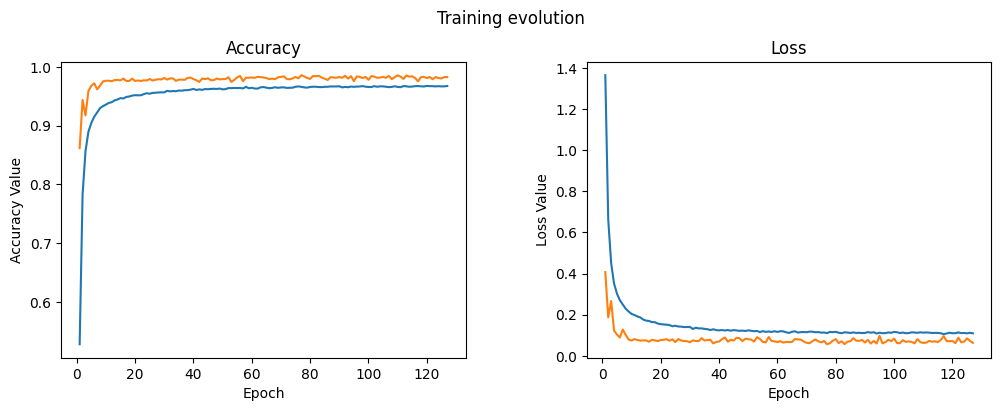

In [ ]:
def plot_evolution(history, epochs):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  t = f.suptitle('Training evolution', fontsize=12)
  f.subplots_adjust(top=0.85, wspace=0.3)

  epoch_list = list(range(1,127+1))
  ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
  ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
  ax1.set_ylabel('Accuracy Value')
  ax1.set_xlabel('Epoch')
  ax1.set_title('Accuracy')

  ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
  ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
  ax2.set_ylabel('Loss Value')
  ax2.set_xlabel('Epoch')
  ax2.set_title('Loss')

plot_evolution(history, epochs)
print(epochs)